In [1]:
import os, shutil, rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

%load_ext autoreload
%autoreload 2

import hydra
import torch
import torch_geometric
from hydra import compose, initialize
from omegaconf import OmegaConf

from topobenchmarkx.data.preprocessor import PreProcessor
from topobenchmarkx.dataloader.dataloader import TBXDataloader
from topobenchmarkx.data.loaders import GraphLoader

from topobenchmarkx.data.batching.neighbor_cells_loader import NeighborCellsLoader
from topobenchmarkx.dataloader import TBXDataloader
from topobenchmarkx.data.preprocessor import PreProcessor
from topomodelx.nn.simplicial.scn2 import SCN2

from topobenchmarkx.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)

initialize(config_path="../configs", job_name="job")

/tmp/ipykernel_99975/2509310254.py:30: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="job")


hydra.initialize()

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from matplotlib.patches import Polygon
from itertools import combinations
from typing import Optional, Dict, List

def plot_graph(
    data,
    face_color_map: Optional[Dict[int, str]] = None,
    node_size: int = 500,
    font_size: int = 12,
    seed: int = 5,
    show: bool = True
) -> plt.Figure:
    """
    Visualize a simplicial complex from a PyTorch Geometric Data object.
    
    Args:
        data: torch_geometric.data.Data object containing the simplicial complex
        face_color_map: Dictionary mapping number of tetrahedrons to colors
        node_size: Size of nodes in the visualization
        font_size: Size of font for labels
        seed: Random seed for layout
        show: Whether to display the plot immediately
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    # Default color map if none provided
    if face_color_map is None:
        face_color_map = {
            0: "pink",
            1: "gray",
            2: "blue",
            3: "blue",
            4: "orange",
            5: "purple",
            6: "red",
            7: "brown",
            8: "black",
            9: "gray",
        }
    
    # Extract vertices
    num_vertices = data.num_nodes if hasattr(data, 'num_nodes') else data.x.shape[0]
    vertices = list(range(num_vertices))
    
    # Extract edges from incidence matrix
    edges = []
    for edge in abs(data.incidence_1.to_dense().T):
        edges.append(torch.where(edge == 1)[0].numpy())
    edges = np.array(edges)
    
    # Extract tetrahedrons if available
    tetrahedrons = []
    if hasattr(data, 'tetrahedrons'):
        tetrahedrons = data.tetrahedrons
    elif hasattr(data, 'incidence_2'):
        # Extract tetrahedrons from incidence_2 matrix if available
        for tetra in abs(data.incidence_2.to_dense().T):
            tetrahedrons.append(torch.where(tetra == 1)[0].tolist())
    
    # Create graph
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    
    # Find triangular cliques
    cliques = list(nx.enumerate_all_cliques(G))
    cliques = [triangle for triangle in cliques if len(triangle) == 3]
    
    # Create layout
    pos = nx.spring_layout(G, seed=seed)
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    
    # Draw nodes and labels
    node_labels = {i: f"v_{n.item()}" for i,n in enumerate(data.n_id)} if hasattr(data, 'n_id') else {i: f"v_{i}" for i in G.nodes()}
    nx.draw(
        G,
        pos,
        labels=node_labels,
        node_size=node_size,
        node_color="skyblue",
        font_size=font_size,
    )
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="g", width=2, alpha=0.5)
    
    # # Add edge labels
    for i, (u, v) in enumerate(edges):
        x = (pos[u][0] + pos[v][0]) / 2
        y = (pos[u][1] + pos[v][1]) / 2
        plt.text(x, y, f"e_{i}", fontsize=font_size - 2, color="r")
    
    # Color the faces (cliques)
    for clique in cliques:
        # Count tetrahedrons containing this clique
        counter = 0
        for tetrahedron in tetrahedrons:
            for comb in combinations(tetrahedron, 3):
                if set(clique) == set(comb):
                    counter += 1
        
        # Create and add polygon
        polygon = [pos[v] for v in clique]
        poly = Polygon(
            polygon,
            closed=True,
            facecolor=face_color_map.get(counter, "gray"),  # Default to gray if counter not in map
            edgecolor="pink",
            alpha=0.3,
        )
        plt.gca().add_patch(poly)
    
    plt.title(f"Graph with cliques colored ({num_vertices} vertices)")
    
    if show:
        plt.show()
    

## Test batching

If batching is done correctly the results on the selected nodes should not change when compared to the results obtained over the whole graph.
We test this to check that our batching strategy is correct.

In [3]:
path = "./graph2simplicial_lifting/"
if os.path.isdir(path):
    shutil.rmtree(path)
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/cocitation_cora", "model=simplicial/scn"], 
              return_hydra_config=True)

dataset_loader = hydra.utils.instantiate(cfg.dataset.loader)
dataset, dataset_dir = dataset_loader.load()
# Preprocess dataset and load the splits
transform_config = cfg.get("transforms", None)
preprocessor = PreProcessor(dataset, dataset_dir, transform_config)
dataset_train, dataset_val, dataset_test = (
    preprocessor.load_dataset_splits(cfg.dataset.split_params)
)

datamodule = TBXDataloader(
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        dataset_test=dataset_test,
        **cfg.dataset.get("dataloader_params", {}),
    )

input_dim = 1433
hidden_channels = 16
out_dim = 7

model = SCN2(input_dim, input_dim, input_dim, n_layers=2)
model.eval()

train_dataloader = datamodule.train_dataloader()
for data in train_dataloader:
    x_0_full, x_1_full, x_2_full = model(data.x_0, data.x_1, data.x_2, data.hodge_laplacian_0, data.hodge_laplacian_1, data.hodge_laplacian_2)
    break

graph_loader = GraphLoader(cfg.dataset.loader.parameters)
dataset, dataset_dir = graph_loader.load()
preprocessed_dataset = PreProcessor(dataset, './', cfg['transforms'])
data = preprocessed_dataset[0]

# Training, validation and split idxs should be defined somewhere, here we use a toy example
rank = 0
if hasattr(data, "x_hyperedges") and rank==1:
    n_cells = data.x_hyperedges.shape[0]
else:
    n_cells = data[f'x_{rank}'].shape[0]

train_prop = 0.5
n_train = int(train_prop * n_cells)
train_mask = torch.zeros(n_cells, dtype=torch.bool)
train_mask[:n_train] = 1

if rank != 0:
    y = torch.zeros(n_cells, dtype=torch.long)
    data.y = y
    
batch_size = 32

# num_neighbors also controls the number of hops (for 2 hops do num_neighbors=[-1, -1])
loader = NeighborCellsLoader(data,
                             rank=rank,
                             num_neighbors=[-1]*3,
                             input_nodes=train_mask,
                             batch_size=batch_size,
                             shuffle=False)

success = []
for i, batch in enumerate(loader):
    x_0_batch, x_1_batch, x_2_batch = model(batch.x_0, batch.x_1, batch.x_2, batch.hodge_laplacian_0, batch.hodge_laplacian_1, batch.hodge_laplacian_2)
    n_ids = batch.n_id[:batch_size]
    success.append(torch.allclose(x_0_full[n_ids, :], x_0_batch[:batch_size, :],atol=1e-03))
    
# The last element might be False since the last batch might not be full
print(f"Batching works: {all(success[:-1])}")

Transform parameters are the same, using existing data_dir: /TopoBenchmark/datasets/graph/cocitation/Cora/graph2simplicial_lifting/131528455


Processing...
Done!


Batching works: True


### Manual Graph

Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_0=[1, 8], down_laplacian_0=[8, 8], up_laplacian_0=[8, 8], adjacency_0=[8, 8], hodge_laplacian_0=[8, 8], incidence_1=[8, 13], down_laplacian_1=[13, 13], up_laplacian_1=[13, 13], adjacency_1=[13, 13], hodge_laplacian_1=[13, 13], incidence_2=[13, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], adjacency_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[8, 1], x_1=[13, 1], x_2=[6, 1], x_3=[1, 1])


Processing...
Done!


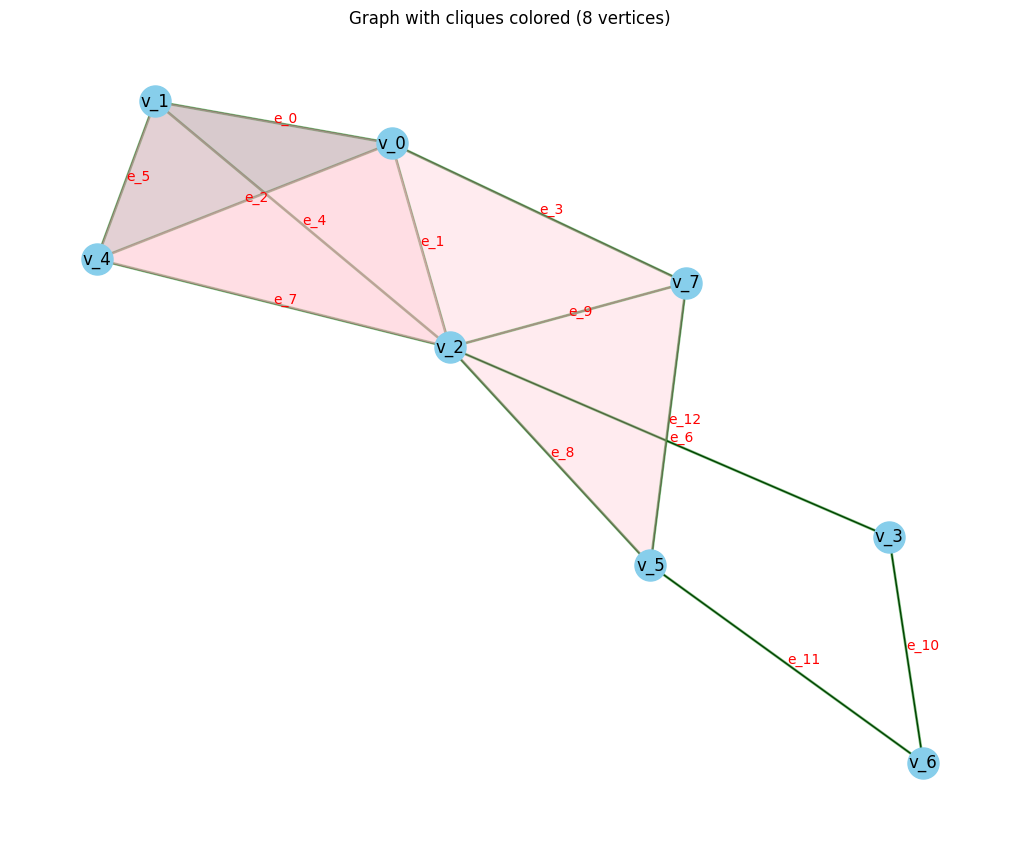

In [4]:
import os, shutil
from topobenchmarkx.data.utils.utils import load_manual_graph

path = "./graph2simplicial_lifting/"
if os.path.isdir(path):
    shutil.rmtree(path)
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/manual_dataset", "model=simplicial/san"], 
              return_hydra_config=True)

data = load_manual_graph()
preprocessed_dataset = PreProcessor(data, './', cfg['transforms'])
data = preprocessed_dataset[0]
print(data)
plot_graph(data)

In [5]:
# Training, validation and split idxs should be defined somewhere, here we use a toy example
rank = 1
if hasattr(data, "x_hyperedges") and rank==1:
    n_cells = data.x_hyperedges.shape[0]
else:
    n_cells = data[f'x_{rank}'].shape[0]

train_prop = 0.5
n_train = int(train_prop * n_cells)
train_mask = torch.zeros(n_cells, dtype=torch.bool)
train_mask[:n_train] = 1

y = torch.zeros(n_cells, dtype=torch.long)
data.y = y

data

Data(x=[8, 1], edge_index=[2, 13], y=[13], num_nodes=8, incidence_0=[1, 8], down_laplacian_0=[8, 8], up_laplacian_0=[8, 8], adjacency_0=[8, 8], hodge_laplacian_0=[8, 8], incidence_1=[8, 13], down_laplacian_1=[13, 13], up_laplacian_1=[13, 13], adjacency_1=[13, 13], hodge_laplacian_1=[13, 13], incidence_2=[13, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], adjacency_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[8, 1], x_1=[13, 1], x_2=[6, 1], x_3=[1, 1])

In [6]:
batch_size = 1

loader = NeighborCellsLoader(data,
                             rank=rank,
                             num_neighbors=[-1,-1],
                             input_nodes=train_mask,
                             batch_size=batch_size,
                             shuffle=False)

/TopoBenchmark/topobenchmarkx/data/batching/utils.py:256: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse.mm(I,I.T)


In [7]:
for batch in loader:
    print(batch)
    print(f"The cells of rank {rank} that were originally selected are {batch.n_id[:batch_size]}")
    print(batch.n_id)
    print(batch.edge_index)
    if hasattr(batch, 'incidence_hyperedges'):
        print(batch.incidence_hyperedges.to_dense())
    else:
        print(batch.incidence_3.to_dense())
        print(batch.incidence_2.to_dense())
        print(batch.incidence_1.to_dense())
    if rank == 0:
        plot_graph(batch)
    break

Data(x=[7, 1], edge_index=[2, 22], y=[11], num_nodes=7, incidence_0=[1, 7], down_laplacian_0=[7, 7], up_laplacian_0=[7, 7], adjacency_0=[7, 7], hodge_laplacian_0=[7, 7], incidence_1=[7, 11], down_laplacian_1=[11, 11], up_laplacian_1=[11, 11], adjacency_1=[11, 11], hodge_laplacian_1=[11, 11], incidence_2=[11, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], adjacency_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[7, 1], x_1=[11, 1], x_2=[6, 1], x_3=[1, 1], cells_ids=[4], n_id=[11])
The cells of rank 1 that were originally selected are tensor([0])
tensor([ 0,  5,  9,  8,  3,  7,  2, 12,  4,  1,  6])
tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 6],
        [1, 2, 4, 6, 0, 2, 4, 0, 1, 3, 4, 5, 6, 2, 0, 1, 2, 2, 6, 0, 2, 5]])
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.]])
tensor([[1., 1., 0., 0., 0., 0.],
 

## Cora hypergraph

In [8]:
path = "./graph2hypergraph_lifting/"
if os.path.isdir(path):
    shutil.rmtree(path)
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/cocitation_cora", "model=hypergraph/allsettransformer"], 
              return_hydra_config=True)
graph_loader = GraphLoader(cfg.dataset.loader.parameters)
dataset, dataset_dir = graph_loader.load()
preprocessed_dataset = PreProcessor(dataset, './', cfg['transforms'])
data = preprocessed_dataset[0]

# Training, validation and split idxs should be defined somewhere, here we use a toy example
rank = 0
if hasattr(data, "x_hyperedges") and rank==1:
    n_cells = data.x_hyperedges.shape[0]
else:
    n_cells = data[f'x_{rank}'].shape[0]

train_prop = 0.5
n_train = int(train_prop * n_cells)
train_mask = torch.zeros(n_cells, dtype=torch.bool)
train_mask[:n_train] = 1

if rank != 0:
    y = torch.zeros(n_cells, dtype=torch.long)
    data.y = y
batch_size = 1

# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])


loader = NeighborCellsLoader(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False)

Processing...
Done!


In [9]:
for batch in loader:
    print(batch)
    print(batch.n_id)
    print(batch.edge_index)
    if hasattr(batch, 'incidence_hyperedges'):
        print(batch.incidence_hyperedges.to_dense())
    else:
        print(batch.incidence_3.to_dense())
        print(batch.incidence_2.to_dense())
        print(batch.incidence_1.to_dense())
        
    break

Data(x=[4, 1433], edge_index=[2, 10556], y=[4], train_mask=[2708], val_mask=[2708], test_mask=[2708], incidence_hyperedges=[2708, 2708], num_hyperedges=2708, x_0=[4, 1433], x_hyperedges=[2708, 1433], incidence_1=[4, 5], num_nodes=4, cells_ids=[2], n_id=[4])
tensor([   0, 1862,  633, 2582])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])
